# Import Packages and Data

In [ ]:
import tensorflow
import keras
import pandas as pd
import numpy as np
np.random.seed(1248)
import sklearn
from sklearn.model_selection import train_test_split
import pickle
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop, Adadelta, Adam

In [17]:
data = pd.read_csv('../data/juliet.csv.zip')
x = pd.read_csv("../data/graph_all.csv.gz")
x['type'] = x['type'] - 1 
y = data.iloc[:,6:]
y_label = y.iloc[x['type']]

In [20]:
flaw = data.iloc[:,4]
flaw = flaw[x['type']]

In [22]:
pd.DataFrame(flaw).to_csv("../data/label.csv")
x = x.drop(columns="type")

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y_label, test_size = 0.2, random_state = 0)

In [10]:
y_train.shape

(48252, 122)

# [Neural tutorial](https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7)

In [72]:
with open('../data/baseline.model','rb') as f:
    model = pickle.load(f)

In [73]:
model.evaluate(x_test,y_test)

12064/12064 [==============================] - 0s 26us/step


[0.767206682371524, 0.7627652519893899]

In [78]:
y_pred = model.predict_classes(x)

In [17]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [18]:
y_predict = model.predict(x_test)

In [11]:
import numpy as np
from matplotlib.colors import LogNorm

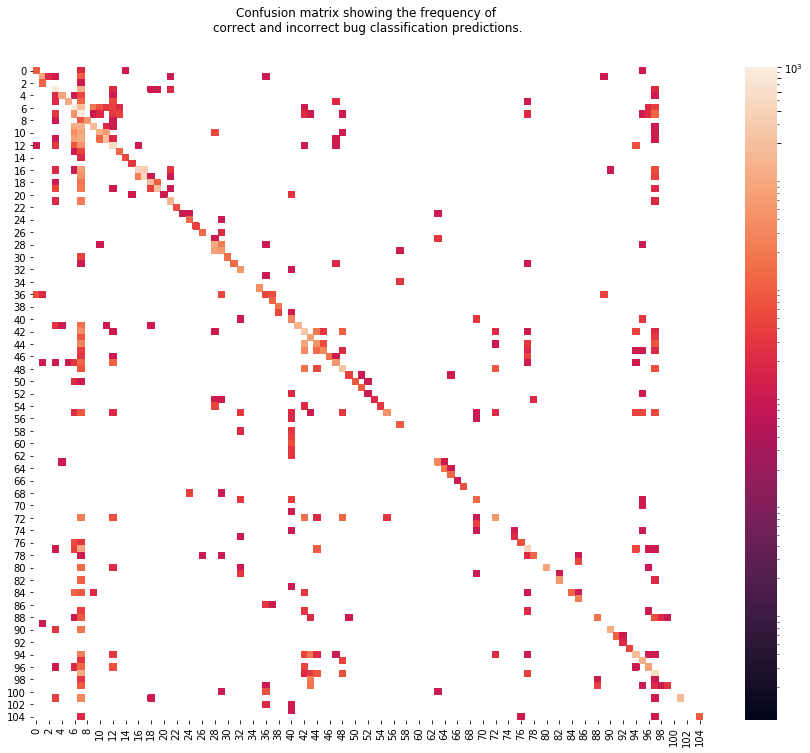

In [40]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix((y_test.values+0).argmax(axis=1), y_predict.argmax(axis=1)), 
)
confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(15, 12)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
sns.heatmap(confusion_matrix, norm=LogNorm(confusion_matrix.min().min(),confusion_matrix.max().max()),
            vmin = 0.001, vmax=1000)


# Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [13]:
rf.score(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


-0.20255167791239043

In [14]:
y_pred = pd.DataFrame(rf.predict(x))

In [15]:
y_pred['label'] = 0
for i in range(0,122):
    y_pred['label'] = y_pred['label'][y_pred[i]==1] = i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
from keras.utils import to_categorical

from visualisation import cve_predict_table

In [17]:
example_script = x_test.iloc[0,]
example_label = y_test.iloc[0,]

In [31]:
cve_predict_table(data, rf, example_script, example_label)

NameError: name 'keras' is not defined

# KNN

## 1NN

In [71]:
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=1,weights = 'distance')
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='distance')

In [45]:
score=knn.score(x_test,y_test)

In [46]:
score

0.5977287798408488

## 3NN

In [47]:
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=3,weights = 'distance')
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')

In [48]:
score=knn.score(x_test,y_test)

In [49]:
score

0.5497347480106101

## Gaussian Naive Bayes

In [20]:
label = y_label.stack()
label = pd.Series(pd.Categorical(label[label!=0].index.get_level_values(1)))

In [19]:
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()
num_label = le.fit_transform(label)

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, num_label, test_size = 0.2, random_state = 0)

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)

print("Number of mislabeled points out of a total %d points : %d"
       % (x_test.shape[0],(y_test != y_pred).sum()))
print("Accuracy " + str(1- (y_test != y_pred).sum()/x_test.shape[0]))

Number of mislabeled points out of a total 12064 points : 8234
Accuracy0.682526525198939


## SVM



In [21]:
from sklearn import svm
clf = svm.SVC(gamma='scale')
clf.fit(x_train, y_train)  

y_pred_svm = clf.predict(x_test)

print("Number of mislabeled points out of a total %d points : %d"
       % (x_test.shape[0],(y_test != y_pred_svm).sum()))
print("Accuracy" + str((y_test != y_pred_svm).sum()/x_test.shape[0]))

Number of mislabeled points out of a total 12064 points : 3463
Accuracy0.2870523872679045


# Save

In [ ]:
x['num_label'] = num_label
x.head()
x.to_csv('../data/visualisation_for_matlab.csv')

In [22]:
label.to_csv('../data/label.csv')